In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
from collections import Counter
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',''])
from nltk.stem import WordNetLemmatizer

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
res_data = pd.read_csv('C:\\Users\\DELL\\Desktop\\Emocusine\\zomato.csv', encoding='latin-1')
countryCode_toName = {
    1: "India",
    14: "Australia",
    30: "Brazil",
    37: "Canada",
    94: "Indonesia",
    148: "New Zealand",
    162: "Phillipines",
    166: "Qatar",
    184: "Singapore",
    189: "South Africa",
    191: "Sri Lanka",
    208: "Turkey",
    214: "UAE",
    215: "United Kingdom",
    216: "United States",
}
res_data['Country'] = res_data['Country Code'].apply(lambda x: countryCode_toName[x])

In [ ]:
res_data = res_data.loc[(res_data['Country Code'] == 1) & (res_data['City'] == 'New Delhi'), :]
res_data = res_data.loc[res_data['Longitude'] != 0, :]
res_data = res_data.loc[res_data['Latitude'] != 0, :]
res_data = res_data.loc[res_data['Latitude'] < 29] # clearing out invalid outlier
res_data = res_data.loc[res_data['Rating text'] != 'Not rated']
res_data['Cuisines'] = res_data['Cuisines'].astype(str)
res_data['fusion_num'] = res_data['Cuisines'].apply(lambda x: len(x.split(',')))
res_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3975 entries, 2561 to 8009
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         3975 non-null   int64  
 1   Restaurant Name       3975 non-null   object 
 2   Country Code          3975 non-null   int64  
 3   City                  3975 non-null   object 
 4   Address               3975 non-null   object 
 5   Locality              3975 non-null   object 
 6   Locality Verbose      3975 non-null   object 
 7   Longitude             3975 non-null   float64
 8   Latitude              3975 non-null   float64
 9   Cuisines              3975 non-null   object 
 10  Average Cost for two  3975 non-null   int64  
 11  Currency              3975 non-null   object 
 12  Has Table booking     3975 non-null   object 
 13  Has Online delivery   3975 non-null   object 
 14  Is delivering now     3975 non-null   object 
 15  Switch to order me

C:\Users\DELL\AppData\Local\Temp\ipykernel_12468\3805284646.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



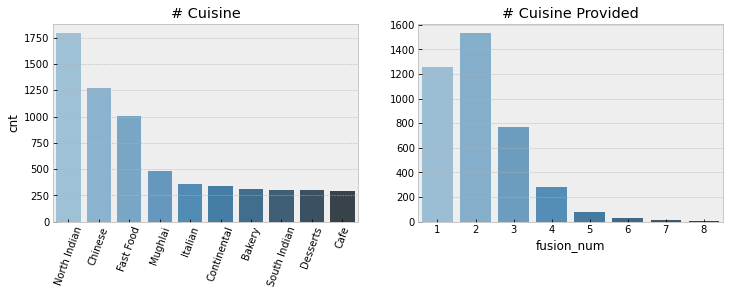

# Unique Cuisine:  78


In [ ]:
lst_cuisine = set()
Cnt_cuisine = Counter()
for cu_lst in res_data['Cuisines']:
    cu_lst = cu_lst.split(',')
    lst_cuisine.update([cu.strip() for cu in cu_lst])
    for cu in cu_lst:
        Cnt_cuisine[cu.strip()] += 1

cnt = pd.DataFrame.from_dict(Cnt_cuisine, orient = 'index')
cnt.sort_values(0, ascending = False, inplace = True)


tmp_cnt = cnt.head(10)
tmp_cnt.rename(columns = {0:'cnt'}, inplace = True)
with plt.style.context('bmh'):
    f = plt.figure(figsize = (12, 8))
    ax = plt.subplot2grid((2,2), (0,0))
    sns.barplot(x = tmp_cnt.index, y = 'cnt', data = tmp_cnt, ax = ax, palette = sns.color_palette('Blues_d', 10))
    ax.set_title('# Cuisine')
    ax.tick_params(axis='x', rotation=70)
    ax = plt.subplot2grid((2,2), (0,1))
    sns.countplot(res_data['fusion_num'], ax=ax, palette = sns.color_palette('Blues_d', res_data.fusion_num.nunique()))
    ax.set_title('# Cuisine Provided')
    ax.set_ylabel('')
    plt.show()        
print('# Unique Cuisine: ', len(lst_cuisine))

In [ ]:
res_data['Rating category'] = res_data['Rating text'].map({'Not rated': -1, 'Poor':0, 'Average':2, 'Good':3, 'Very Good':4, 'Excellent':5})
tmp = res_data['Aggregate rating'].map(np.round)
a = np.full(tmp.shape[0], False, dtype = bool)
((tmp - res_data['Rating category']).map(np.round)).value_counts()
sys_check = res_data[['Aggregate rating', 'Rating category', 'Votes']].copy()
sys_check['distorted'] = (res_data['Aggregate rating'] - res_data['Rating category']).map(np.round)
sys_check['diff'] = sys_check['Aggregate rating'] - sys_check['Rating category']
res_data = res_data.loc[sys_check['distorted'] != 2, :]
res_data['Rating category'] = res_data['Aggregate rating'].round(0).astype(int)

C:\Users\DELL\AppData\Local\Temp\ipykernel_12468\3019904164.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



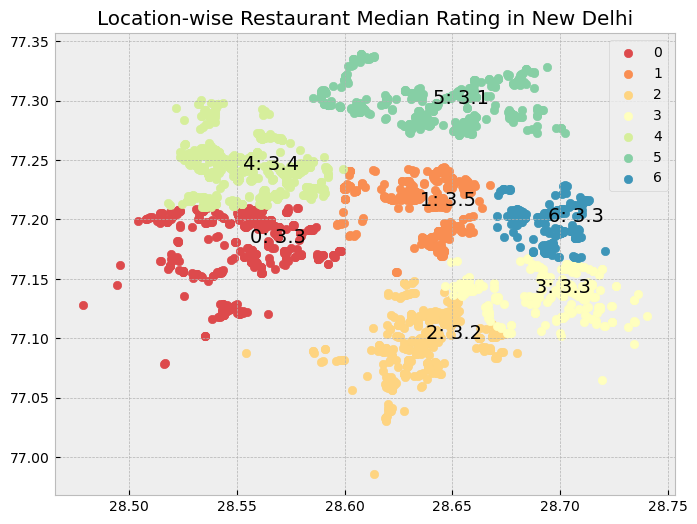

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=0).fit(res_data[['Longitude', 'Latitude']])
res_data['pos'] = kmeans.labels_
pop_local = res_data.groupby('pos')['Longitude', 'Latitude', 'Aggregate rating'].agg({'Longitude':np.mean, 'Latitude':np.mean, 'Aggregate rating':np.median}).reset_index()

with plt.style.context('bmh', after_reset=True):
    pal = sns.color_palette('Spectral', 7)
    plt.figure(figsize = (8,6))
    for i in range(7):
        ix = res_data.pos == i
        plt.scatter(res_data.loc[ix, 'Latitude'], res_data.loc[ix, 'Longitude'], color = pal[i], label = str(i))
        plt.text(pop_local.loc[i, 'Latitude'], pop_local.loc[i, 'Longitude'], str(i) + ': '+str(pop_local.loc[i, 'Aggregate rating'].round(2)), fontsize = 14, color = 'black')
    plt.title('Location-wise Restaurant Median Rating in New Delhi')
    plt.legend()
    plt.show()

In [ ]:
food_data = pd.read_csv('C:\\Users\\DELL\\Desktop\\Emocusine\\food_choices.csv')
food_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   GPA                           123 non-null    object 
 1   Gender                        125 non-null    int64  
 2   breakfast                     125 non-null    int64  
 3   calories_chicken              125 non-null    int64  
 4   calories_day                  106 non-null    float64
 5   calories_scone                124 non-null    float64
 6   coffee                        125 non-null    int64  
 7   comfort_food                  124 non-null    object 
 8   comfort_food_reasons          124 non-null    object 
 9   comfort_food_reasons_coded    106 non-null    float64
 10  cook                          122 non-null    float64
 11  comfort_food_reasons_coded.1  125 non-null    int64  
 12  cuisine                       108 non-null    float64
 13  diet_

In [ ]:
food_data[['comfort_food_reasons', 'comfort_food']]

,comfort_food_reasons,comfort_food
0,we dont have comfort,none
1,"Stress, bored, anger","chocolate, chips, ice cream"
2,"stress, sadness","frozen yogurt, pizza, fast food"
3,Boredom,"Pizza, Mac and cheese, ice cream"
4,"Stress, boredom, cravings","Ice cream, chocolate, chips"
...,...,...
120,boredom and sadness,"wine. mac and cheese, pizza, ice cream"
121,Loneliness / Homesick / Sadness,Pizza / Wings / Cheesecake
122,sadness,"rice, potato, seaweed soup"
123,"happiness, they are some of my favorite foods","Mac n Cheese, Lasagna, Pizza"


In [ ]:
def search_comfort(mood):
    lemmatizer = WordNetLemmatizer()
    foodcount = {}
    for i in range(124):
        temp = [temps.strip().replace('.','').replace(',','').lower() for temps in str(food_data["comfort_food_reasons"][i]).split(' ') if temps.strip() not in stop ]
        if mood in temp:
            foodtemp = [lemmatizer.lemmatize(temps.strip().replace('.','').replace(',','').lower()) for temps in str(food_data["comfort_food"][i]).split(',') if temps.strip() not in stop ]
            for a in foodtemp:
                if a not in foodcount.keys():
                    foodcount[a] = 1 
                else:
                    foodcount[a] += 1
    sorted_food = []
    sorted_food = sorted(foodcount, key=foodcount.get, reverse=True)
    return sorted_food


def find_my_comfort_food(mood):
    topn = []
    topn = search_comfort(mood) #function create dictionary only for particular mood
    print("3 Popular Comfort Foods in %s are:"%(mood))
    print(topn[0])
    print(topn[1])
    print(topn[2])

In [ ]:
find_my_comfort_food('sad')

3 Popular Comfort Foods in sad are:
ice cream
pizza
chip


In [ ]:
res_data[res_data.Cuisines.str.contains('pizza', case=False)].sort_values(by='Aggregate rating', ascending=False).head(3)

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes,Country,fusion_num,Rating category,pos
3658,18400736,Owl is Well,1,New Delhi,"Greater Kailash (GK) 1, New Delhi",Greater Kailash (GK) 1,"Greater Kailash (GK) 1, New Delhi",77.240703,28.541636,"Burger, American, Fast Food, Italian, Pizza",...,No,3,4.5,Dark Green,Excellent,162,India,5,4,4
4665,18419910,Civil House,1,New Delhi,"26, Khan Market, New Delhi",Khan Market,"Khan Market, New Delhi",77.227358,28.600257,"European, Continental, Pizza",...,No,3,4.2,Green,Very Good,113,India,3,4,1
6850,313269,Tossin Pizza,1,New Delhi,"B-6/2, Safdarjung Enclave, Opposite Deer Park,...",Safdarjung,"Safdarjung, New Delhi",77.195728,28.559335,"Pizza, Italian",...,No,2,4.1,Green,Very Good,647,India,2,4,0
